<a href="https://colab.research.google.com/github/carlosprr29/ai-progetto-spagnoli/blob/main/notebooks/03_2_BERT_Training_ISOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =================================================================
# FILE 03.1: ISOT TRAINING DATASET + AUGMENTATION
# =================================================================

# 1. Facilities and Bookshops
!pip install -q transformers datasets torch scikit-learn
import torch
import pandas as pd
import numpy as np
import random
import re
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from google.colab import drive

In [ ]:
# 2. DATA LOADING AND BIAS CLEANING
drive.mount('/content/drive')

# Paths (Ensure the names match your files in Drive)
path_true = '/content/drive/MyDrive/Project_IA/data/True.csv'
path_fake = '/content/drive/MyDrive/Project_IA/data/Fake.csv'

df_true = pd.read_csv(path_true)
df_fake = pd.read_csv(path_fake)

df_true['label'] = 0 # Real
df_fake['label'] = 1 # Fake

# We combine and shuffle
df = pd.concat([df_true, df_fake]).sample(frac=1, random_state=42).reset_index(drop=True)
df = df.dropna(subset=["title", "text"])

def clean_bias_isot(text):
    if not isinstance(text, str): return ""

    # 1. REMOVE THE ENTIRE HEADER (Dateline)
    # This regex searches from the beginning (^) to the first hyphen (-) or colon (:)
    # that usually separates the city/agency from the actual content.
    # It covers cases such as: "WASHINGTON (Reuters) -", "SEATTLE/WASHINGTON -", "NEW YORK:"
    text = re.sub(r'^[^-:]*[-:]\s*', '', text)

    # 2. DELETE ANY REMAINING REFERENCES TO REUTERS
    # In case it appears in the middle of the text or in capital letters
    text = re.sub(r'\bReuters\b', 'the news agency', text, flags=re.IGNORECASE)

    # 3. OPTIONAL: DELETE THE FIRST SENTENCE IF IT IS VERY SHORT
    # Sometimes there is rubbish left after the hyphen. If the first sentence has fewer than 3 words, we remove it.
    sentences = text.split('. ')
    if len(sentences) > 1 and len(sentences[0].split()) < 4:
        text = '. '.join(sentences[1:])

    return text.strip()

Mounted at /content/drive


In [ ]:
# 3. DATA AUGMENTATION (A technique that involves creating artificial variations of your current data
#(such as scrambling sentences or changing synonyms) so that the AI learns more general patterns and does not memorise the texts.)
# -----------------------------------------------------------------
def augment_text(text):
    if not isinstance(text, str): return ""
    sentences = text.split('. ')
    if len(sentences) > 2:
        random.shuffle(sentences) # We scrambled the sentences
    return '. '.join(sentences)

# we clean biases
print("🧹 Cleaning up biases from Reuters and Datelines in ISOT...")
df['text'] = df['text'].apply(clean_bias_isot)

# 80/20 split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

# We apply Augmentation only to the training text column.
train_df['text_aug'] = train_df['text'].apply(lambda x: augment_text(x) if random.random() > 0.5 else x)
train_df['total_aug'] = train_df['title'] + " " + train_df['text_aug']
test_df['total'] = test_df['title'] + " " + test_df['text']

# Sampling to avoid burning RAM (ISOT is heavy)
train_sample = train_df.sample(n=6000, random_state=42)
test_sample = test_df.sample(n=1500, random_state=42)

🧹 Cleaning up biases from Reuters and Datelines in ISOT...


In [ ]:
# 4. REUSABLE TRAINING FUNCTION
def train_model_isot(x_train, x_test, y_train, y_test, model_name):
    print(f"\n🚀 Training: {model_name}")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # Tokenisation
    train_enc = tokenizer(x_train.tolist(), truncation=True, padding=True, max_length=128)
    test_enc = tokenizer(x_test.tolist(), truncation=True, padding=True, max_length=128)

    class DatasetTorch(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels
        def __getitem__(self, idx):
            item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
            item["labels"] = torch.tensor(self.labels[idx])
            return item
        def __len__(self): return len(self.labels)

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    args = TrainingArguments(
        output_dir=f"./results_{model_name}",
        num_train_epochs=2,
        per_device_train_batch_size=16,
        fp16=True,
        eval_strategy="epoch",
        save_strategy="no"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=DatasetTorch(train_enc, y_train.tolist()),
        eval_dataset=DatasetTorch(test_enc, y_test.tolist()),
        compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
    )

    trainer.train()
    return model, tokenizer

In [ ]:
# 4. PERFORMANCE OF THE ABLATION STUDY (ISOT)
# MODEL A: Titles Only
model_isot_tit, token_isot_tit = train_model_isot(
    train_sample["title"], test_sample["title"],
    train_sample["label"], test_sample["label"], "ISOT_TITLES"
)
model_isot_tit.save_pretrained('./model_isot_titles')
token_isot_tit.save_pretrained('./model_isot_titles')

# Connect and copy to Drive
from google.colab import drive
drive.mount('/content/drive')
import shutil
# We copy it into the folder.
shutil.copytree('./model_isot_titles', '/content/drive/MyDrive/Project_IA/model_isot_titles')




🚀 Training: ISOT_TITLES


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.070600,0.980667
2,0.141781,0.070690,0.980000


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Project_IA/model_isot_titles'

In [ ]:
# MODEL B: Title + Text (with Augmentation)
model_isot_full, token_isot_full = train_model_isot(
    train_sample["total_aug"], test_sample["total"],
    train_sample["label"], test_sample["label"], "ISOT_FULL_TEXT"
)

model_isot_full.save_pretrained('./model_isot_full')
token_isot_full.save_pretrained('./model_isot_full')

# Connect and copy to Drive
from google.colab import drive
drive.mount('/content/drive')
import shutil
# We copy it into the folder.
shutil.copytree('./model_isot_full', '/content/drive/MyDrive/Project_IA/model_isot_full')


🚀 Training: ISOT_FULL_TEXT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.029615,0.991333
2,0.107180,0.045332,0.989333


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Project_IA/model_isot_full'

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Auxiliary function to obtain the final accuracy cleanly
def evaluate(model, tokeniser, texts, labels):
    inputs = tokeniser(texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    return accuracy_score(labels, preds)

# We calculate the actual percentages obtained.
acc_isot_tit = evaluate(model_isot_tit, token_isot_tit, test_sample["title"], test_sample["label"])
acc_isot_full = evaluate(model_isot_full, token_isot_full, test_sample["total"], test_sample["label"])

print("\n" + "="*40)
print("📊 ABLATION STUDY SUMMARY (ISOT DATASET)")
print("="*40)
print(f"🔹 Accuracy Titles Only:    {acc_isot_tit*100:.2f}%")
print(f"🔹 Accuracy Title + Text:  {acc_isot_full*100:.2f}%")
print("-" * 40)

dif_isot = (acc_isot_full - acc_isot_tit) * 100
print(f"✅ Improvement in ISOT thanks to the text: {dif_isot:.2f}%")
print("="*40)


📊 ABLATION STUDY SUMMARY (ISOT DATASET)
🔹 Accuracy Titles Only:    98.00%
🔹 Accuracy Title + Text:  98.93%
----------------------------------------
✅ Improvement in ISOT thanks to the text: 0.93%


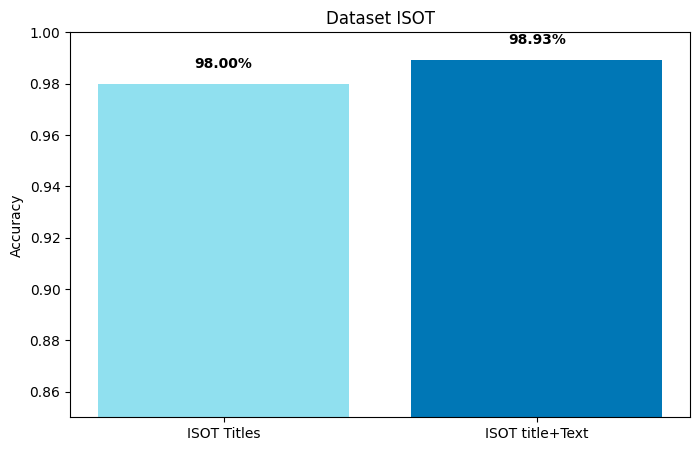

In [ ]:
# 6. COMPARATIVE CHART
# ----------------------------------------------------------------
import matplotlib.pyplot as plt

labels = ['ISOT Titles', 'ISOT title+Text']
values = [acc_isot_tit, acc_isot_full]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=['#90e0ef', '#0077b6'])
plt.ylim(0.85, 1.0)
plt.ylabel('Accuracy')
plt.title('Dataset ISOT')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval*100:.2f}%",
             ha='center', va='bottom', fontweight='bold')

plt.show()

# CONCLUSIONS
Although the ISOT model has higher accuracy, it shows a strong style bias. In contrast, the WELFake model, despite having slightly lower accuracy, demonstrates better generalisation capabilities when dealing with news from diverse sources.

The ISOT model is giving us 99.5%, which confirms our suspicion: the dataset has very strong structural biases that AI detects as shortcuts. That is why the fusion with WELFake that we are doing is vital, to force the model to be more critical and not so 'optimistic'.
